<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_SetFlow_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_models.py",
    "vqvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vqvae_models.py",
    "setflowvae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/setflowvae_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_models.py downloaded successfully.
vqvae_models.py downloaded successfully.
setflowvae_models.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_models
import vqvae_models
import setflowvae_models

from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data
from Dataloader import prepare_data_for_ISAB
from mogvae_models import MoGVAE
from vqvae_models import VQVAE
from setflowvae_models import *

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.75 GB


In [14]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))
# SetVAEモデル構築
vae = SetVAE(
    n_in=3,                  # 点群データの3次元座標 (x, y, z)
    n_z=32,                  # 潜在空間の次元
    num_heads=4,             # ISAB のヘッド数
    num_inducing_points=16,  # ISAB の誘導点の数
    num_flows=2              # Normalizing Flow のフロー数
).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.00001)

9


In [15]:
z_list = None  # z_list を初期化
epochs = 5000
interval = 100

rec_error_record = []
reg_error_record = []
total_error_record = []
for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_total = 0

    for k, (x,) in enumerate(data_loader):
        # xをdeviceに移動
        x = x.to(device)
        # print(f"Input shape to VAE: {x.shape}")  # デバッグ用

        # ISAB向けに (batch_size, num_points, channels) の形状を確保
        x = x.view(1, num_points, 3)  # 1バッチ、num_points個の点、3次元特徴

        # VAEの出力と損失を計算
        y, mu, logvar = vae(x)  # ISAB-SetVAEの出力に合わせる
        recon_loss, kl_div = vae.loss(y, x, mu, logvar)  # VAEのloss関数を使用

        # 損失の合計を計算
        loss = recon_loss + kl_div
        loss_rec += recon_loss.item()
        loss_reg += kl_div.item()
        loss_total += loss.item()

        # 最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 最終エポックでz_listを保存
        if i == epochs - 1:
            z_np = mu.cpu().detach().numpy()
            if z_list is None:
                z_list = z_np  # 初回のみ初期化
            else:
                if z_list.shape[1] == z_np.shape[1]:  # shape[1] (embedding_dim) が一致する場合のみ結合
                    z_list = np.vstack((z_list, z_np))
                else:
                    print(f"Shape mismatch: z_list.shape={z_list.shape}, z_np.shape={z_np.shape} — Skipping this batch.")

    # 平均を計算
    loss_rec /= (k + 1)
    loss_reg /= (k + 1)
    loss_total /= (k + 1)

    # ログの記録
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# 最終エポック後に z_list を保存
if z_list is not None:
    np.save("z_list_final.npy", z_list)
    print(f"z_list saved with shape: {z_list.shape}")

# z_listを結合
z_list = np.concatenate(z_list, axis=0)

Epoch:0 Loss_Rec:8679.064507378473 Loss_Reg:0.08859012524286906 Loss_Total:8679.153157552084
Epoch:100 Loss_Rec:1982.5552978515625 Loss_Reg:4.621715545654297 Loss_Total:1987.177029079861
Epoch:200 Loss_Rec:1757.3804389105903 Loss_Reg:8.625768767462837 Loss_Total:1766.0062120225693
Epoch:300 Loss_Rec:1523.2608100043403 Loss_Reg:12.385357220967611 Loss_Total:1535.6461724175347
Epoch:400 Loss_Rec:1466.4537082248264 Loss_Reg:16.46681276957194 Loss_Total:1482.9205050998264
Epoch:500 Loss_Rec:1464.6045939127605 Loss_Reg:21.73275375366211 Loss_Total:1486.3373345269097
Epoch:600 Loss_Rec:1358.2746717664932 Loss_Reg:27.351367738511826 Loss_Total:1385.6260375976562
Epoch:700 Loss_Rec:1344.7777167426216 Loss_Reg:33.00941785176595 Loss_Total:1377.787136501736
Epoch:800 Loss_Rec:1295.4582655164932 Loss_Reg:36.32673475477431 Loss_Total:1331.7849934895833
Epoch:900 Loss_Rec:1295.8540717230903 Loss_Reg:35.93994352552626 Loss_Total:1331.7939995659722
Epoch:1000 Loss_Rec:1301.3961995442708 Loss_Reg:37.0

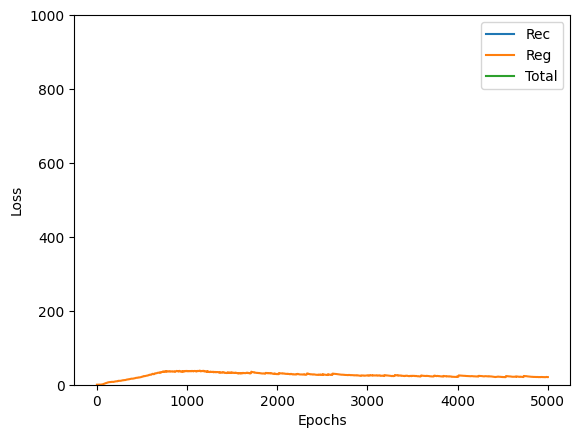

Model weights have been saved!


In [16]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
#torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/VQVAE_Np5000_MSE_0216.pth')
print("Model weights have been saved!")

In [ ]:
print(z_list) # z mu logvar

# 再構成形状の可視化

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (0,).

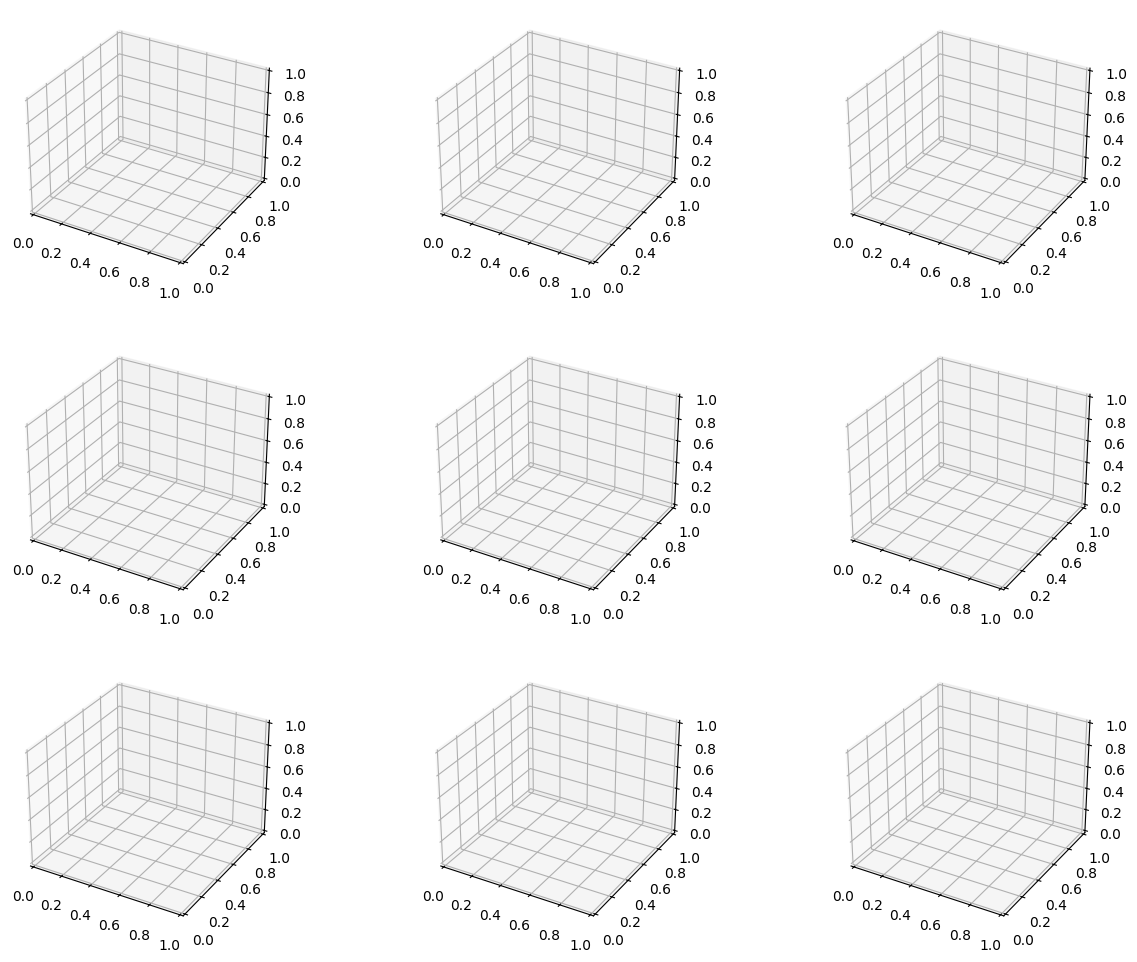

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)
    # 再構築 (z を 1バッチの形に変換して decode)
    #recon_batch = vae.decode(z)  # z をバッチの形状に変換

    # CPU上で detach して numpy に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_points に基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chamfer Distanceの計算
chamfer_distances = []
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

In [ ]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    in_z = z.unsqueeze(0)  # (64,) -> (1, 64)
    recon_batch = vae.decode(in_z)

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
